# Threshold of Population Sustainability in Japan
## Yu Cao, Nick Williams, Aidan McGovern


## Introduction 

Over the better part of the 20th century, Japan has transformed itself from a primarily agrarian society into a modern industrial super power. While japanese life expectancy has increased substantially over time, the effects of industrialization have pressured the japanese population to prioritize their place in the workforce over reproduction. As a result, the life expectancy of the Japanese has increased while the birth rate has experienced a consistent decline. Some sources predict a negative japanese birth rate as early as 2020. 

In this project, we will be exploring the effects of industrialization in tandum with societal pressure in japanese culture in order to guage if Japan may be quickly approaching their threshold for healthy population sustainability. With that result, we will recommend action that Japan can take to reduce the chances of or potentially entirely avoid societal collapse. 

Once we have determined a set of features that have potential to influence this phenomenon, we will train a machine learning model to determine the best application of these features toward the goal of avoiding societal collapse.


# Part 1 - Exploratory Data Analysis


What can we observe from the raw population data of Japan

### Retrieve Japanese Population Dataset

In [0]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

r = requests.get("https://raw.githubusercontent.com/eyucao/csvhold/master/Japan_population_data.csv")
df = BeautifulSoup(r.text)

### Clean the data

In [3]:
df2 = df.getText().split('\n')
i = 0
df3 = []
for line in df2:
    if i == 0:
        colnames = line.split(',')
        i = 1
    else:
        df3.append(line.split(','))
df3 = df3[:-1]
colnames[6] = colnames[6][:-1]
population_data = pd.DataFrame(data = df3, columns = colnames)
population_data.dropna()
population_data.reset_index(drop=True, inplace = True)
population_data.head(10)

,prefecture,year,population,capital,region,estimated_area,island
0,Aichi-ken,1872.1667,1210368,Nagoya-shi,Chubu,5165.12,Honshu\r
1,Aichi-ken,1873,1217444,Nagoya-shi,Chubu,5165.12,Honshu\r
2,Aichi-ken,1874,1217521,Nagoya-shi,Chubu,5165.12,Honshu\r
3,Aichi-ken,1875,1234003,Nagoya-shi,Chubu,5165.12,Honshu\r
4,Aichi-ken,1876,1244711,Nagoya-shi,Chubu,5165.12,Honshu\r
5,Aichi-ken,1877,1250839,Nagoya-shi,Chubu,5165.12,Honshu\r
6,Aichi-ken,1878,1267206,Nagoya-shi,Chubu,5165.12,Honshu\r
7,Aichi-ken,1879,1295452,Nagoya-shi,Chubu,5165.12,Honshu\r
8,Aichi-ken,1880,1303812,Nagoya-shi,Chubu,5165.12,Honshu\r
9,Aichi-ken,1881,1317792,Nagoya-shi,Chubu,5165.12,Honshu\r


### Calculate the Rate of Change in Population

In [4]:
for index, row in population_data.iterrows():
    row['island'] = str(row['island'])[:-1]
    # print(row['island'])
population_data.head(10)

for index, row in population_data.iterrows():
    #print(row['year'])
    row['year'] = int(float(row['year']))

prev = {}
popdelta = {}
population_data = population_data[population_data.population != 'NA']
population_data.reset_index(drop=True, inplace = True)
for index, row in population_data.iterrows():
    if row['prefecture'] in prev:
        #print(row['population'])
        popdelta[index] = int(row['population']) - int(prev[row['prefecture']])
        prev[row['prefecture']] = row['population']
    else:
        popdelta[index] = 0
        prev[row['prefecture']] = row['population']
popdelta

{0: 0,
 1: 7076,
 2: 77,
 3: 16482,
 4: 10708,
 5: 6128,
 6: 16367,
 7: 28246,
 8: 8360,
 9: 13980,
 10: 14258,
 11: 22946,
 12: 15580,
 13: 2843,
 14: 13054,
 15: 17633,
 16: 25380,
 17: 14525,
 18: 12283,
 19: 16805,
 20: 10645,
 21: 14047,
 22: 14629,
 23: 16929,
 24: 24098,
 25: 23873,
 26: 15413,
 27: 46878,
 28: 112431,
 29: 134697,
 30: 186485,
 31: 66853,
 32: -50315,
 33: 229732,
 34: 247919,
 35: 295288,
 36: 303891,
 37: 113614,
 38: -422355,
 39: 61234,
 40: 203817,
 41: 103214,
 42: 164469,
 43: 378624,
 44: 437104,
 45: 592340,
 46: 587510,
 47: 537406,
 48: 298069,
 49: 233534,
 50: 235431,
 51: 177733,
 52: 174964,
 53: 211404,
 54: 156015,
 55: 73375,
 56: 0,
 57: -438,
 58: 14782,
 59: 7473,
 60: 5306,
 61: 3969,
 62: 2759,
 63: 4982,
 64: -2297,
 65: 6673,
 66: 2929,
 67: 4768,
 68: 7372,
 69: -1316,
 70: 5108,
 71: 9670,
 72: 8880,
 73: 20011,
 74: 7194,
 75: 7176,
 76: 6184,
 77: 9256,
 78: 8133,
 79: 6103,
 80: 10948,
 81: 10436,
 82: 8683,
 83: 24088,
 84: 56536,

In [5]:
population_data['pop_delta'] = 1
for index,row in population_data.iterrows():
    if index in popdelta.keys():
        #row['pop_delta']
        population_data.iat[index,7] = popdelta[index]
population_data.head(10)

,prefecture,year,population,capital,region,estimated_area,island,pop_delta
0,Aichi-ken,1872,1210368,Nagoya-shi,Chubu,5165.12,Honshu,0
1,Aichi-ken,1873,1217444,Nagoya-shi,Chubu,5165.12,Honshu,7076
2,Aichi-ken,1874,1217521,Nagoya-shi,Chubu,5165.12,Honshu,77
3,Aichi-ken,1875,1234003,Nagoya-shi,Chubu,5165.12,Honshu,16482
4,Aichi-ken,1876,1244711,Nagoya-shi,Chubu,5165.12,Honshu,10708
5,Aichi-ken,1877,1250839,Nagoya-shi,Chubu,5165.12,Honshu,6128
6,Aichi-ken,1878,1267206,Nagoya-shi,Chubu,5165.12,Honshu,16367
7,Aichi-ken,1879,1295452,Nagoya-shi,Chubu,5165.12,Honshu,28246
8,Aichi-ken,1880,1303812,Nagoya-shi,Chubu,5165.12,Honshu,8360
9,Aichi-ken,1881,1317792,Nagoya-shi,Chubu,5165.12,Honshu,13980


### Calculate the Rate of Change in Population Change

In [6]:
pref = {}
for index, row in population_data.iterrows():
    if row['prefecture'] not in pref.keys():
        pref[row['prefecture']] = 0
#need to get delta delta
population_data['pop_delta_delta'] = -1 *(population_data['pop_delta'] - population_data['pop_delta'].shift(-1))
population_data['pop_delta_delta'] = population_data['pop_delta_delta'].shift(1)

population_data['pdd_percent'] = -1 *(population_data['pop_delta_delta'].shift(-1) / population_data['pop_delta'])
population_data['pdd_percent'] = population_data['pdd_percent'].shift(1)
population_data.head(10)

,prefecture,year,population,capital,region,estimated_area,island,pop_delta,pop_delta_delta,pdd_percent
0,Aichi-ken,1872,1210368,Nagoya-shi,Chubu,5165.12,Honshu,0,NaN,NaN
1,Aichi-ken,1873,1217444,Nagoya-shi,Chubu,5165.12,Honshu,7076,7076.0,-inf
2,Aichi-ken,1874,1217521,Nagoya-shi,Chubu,5165.12,Honshu,77,-6999.0,0.989118
3,Aichi-ken,1875,1234003,Nagoya-shi,Chubu,5165.12,Honshu,16482,16405.0,-213.051948
4,Aichi-ken,1876,1244711,Nagoya-shi,Chubu,5165.12,Honshu,10708,-5774.0,0.350322
5,Aichi-ken,1877,1250839,Nagoya-shi,Chubu,5165.12,Honshu,6128,-4580.0,0.427718
6,Aichi-ken,1878,1267206,Nagoya-shi,Chubu,5165.12,Honshu,16367,10239.0,-1.670855
7,Aichi-ken,1879,1295452,Nagoya-shi,Chubu,5165.12,Honshu,28246,11879.0,-0.725790
8,Aichi-ken,1880,1303812,Nagoya-shi,Chubu,5165.12,Honshu,8360,-19886.0,0.704029
9,Aichi-ken,1881,1317792,Nagoya-shi,Chubu,5165.12,Honshu,13980,5620.0,-0.672249


In [7]:
prevs = []

for index, row in population_data.iterrows():
    #print(row['prefecture'])
    if row['prefecture'] not in prevs:
        prevs.append(row['prefecture'])
        population_data.iat[index,9] = 0
        population_data.iat[index,8] = 0
#print(prevs)

population_data['pop_delta_delta'] = population_data['pop_delta_delta'].shift(-1)
population_data['pdd_percent'] = population_data['pdd_percent'].shift(-1)
prevs.clear()
for index, row in population_data.iterrows():
    #print(row['prefecture'])
    if row['prefecture'] not in prevs:
        prevs.append(row['prefecture'])
        population_data.iat[index,9] = 0
        population_data.iat[index,8] = 0

population_data['pop_delta_delta'] = population_data['pop_delta_delta'].shift(1)
population_data['pdd_percent'] = population_data['pdd_percent'].shift(1)
population_data.head(10)

,prefecture,year,population,capital,region,estimated_area,island,pop_delta,pop_delta_delta,pdd_percent
0,Aichi-ken,1872,1210368,Nagoya-shi,Chubu,5165.12,Honshu,0,NaN,NaN
1,Aichi-ken,1873,1217444,Nagoya-shi,Chubu,5165.12,Honshu,7076,0.0,0.000000
2,Aichi-ken,1874,1217521,Nagoya-shi,Chubu,5165.12,Honshu,77,-6999.0,0.989118
3,Aichi-ken,1875,1234003,Nagoya-shi,Chubu,5165.12,Honshu,16482,16405.0,-213.051948
4,Aichi-ken,1876,1244711,Nagoya-shi,Chubu,5165.12,Honshu,10708,-5774.0,0.350322
5,Aichi-ken,1877,1250839,Nagoya-shi,Chubu,5165.12,Honshu,6128,-4580.0,0.427718
6,Aichi-ken,1878,1267206,Nagoya-shi,Chubu,5165.12,Honshu,16367,10239.0,-1.670855
7,Aichi-ken,1879,1295452,Nagoya-shi,Chubu,5165.12,Honshu,28246,11879.0,-0.725790
8,Aichi-ken,1880,1303812,Nagoya-shi,Chubu,5165.12,Honshu,8360,-19886.0,0.704029
9,Aichi-ken,1881,1317792,Nagoya-shi,Chubu,5165.12,Honshu,13980,5620.0,-0.672249


### Put All Computed Features Together

In [8]:
pop_yr = {}

for index, row in population_data.iterrows():
    if row['year'] in pop_yr:
        #print(row['population'])
        pop_yr[row['year']] += int(row['population'])
    else:
        pop_yr[row['year']] = 0

total_pop = pd.DataFrame([list(pop_yr.keys()),list(pop_yr.values())])
total_pop = total_pop.T
total_pop.columns = ['year','population']
total_pop.iat[14,1] = int(total_pop.iat[14,1] /2)
total_pop.head(10)

,year,population
0,1872,26858564
1,1873,27840112
2,1874,29388390
3,1875,29718092
4,1876,30590571
5,1877,33377526
6,1878,33631370
7,1879,34473104
8,1880,34625009
9,1881,35041202


In [99]:
total_pop['pop_delta'] = -1 *( total_pop['population'] - total_pop['population'].shift(-1))
total_pop['pop_delta'] = total_pop['pop_delta'].shift(1)

total_pop['pop_delta_delta'] = -1* ( total_pop['pop_delta'] - total_pop['pop_delta'].shift(-1))
total_pop['pop_delta_delta'] = total_pop['pop_delta_delta'].shift(1)

total_pop['pd_decrease'] = -1 * ( total_pop['pop_delta_delta'].shift(-1) / total_pop['pop_delta'])
#total_pop['pop_delta_delta'] = total_pop['pop_delta_delta'].shift(1)
total_pop['pd_decrease'] = total_pop['pd_decrease'].shift(1)

total_pop['year'] = pd.to_numeric(total_pop['year'], errors='coerce')

total_pop.rename(columns={'year':'Year'}, inplace=True)

total_pop.head()

,Year,population,pop_delta,pop_delta_delta,pd_decrease
0,1872,26858564,NaN,NaN,NaN
1,1873,27840112,981548.0,NaN,NaN
2,1874,29388390,1548278.0,566730.0,-0.577384
3,1875,29718092,329702.0,-1218576.0,0.787052
4,1876,30590571,872479.0,542777.0,-1.646265


# Part 2 - Analysis of Factors

We're now going to take a look at some other attributes of Japan to determine if we can relate them to Japan's population rate of change

### Retrieve and Clean Japanese Urban Population Data

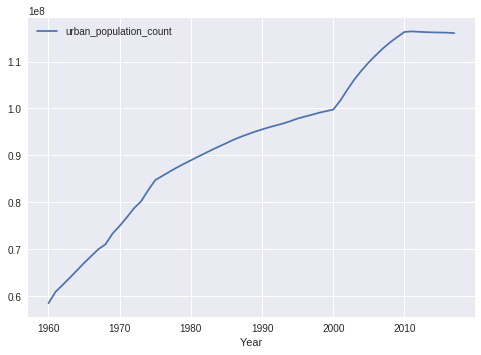

In [101]:
world_urban_pop = pd.read_csv("https://raw.githubusercontent.com/nickwilliams2020/csvhold/master/world_urban_population.csv")
world_urban_pop

japan_urban_pop = world_urban_pop[raw_world_fert_rates['Country Name'] == 'Japan']

japan_urban_pop = japan_urban_pop.drop(columns=['Country Name', 'Country Code', 'Indicator Code', 'Indicator Name' ]).T

japan_urban_pop['Year'] = japan_urban_pop.index
japan_urban_pop.columns = ['urban_population_count', 'Year']


japan_urban_pop.index = [i for i in range(0,len(japan_urban_pop.index))]
japan_urban_pop
japan_urban_pop['Year'] = pd.to_numeric(japan_urban_pop['Year'], errors='coerce')
japan_urban_pop['urban_population_count'] = pd.to_numeric(japan_urban_pop['urban_population_count'], errors='coerce')
japan_urban_pop.plot.line(x='Year', y='urban_population_count')

### Retrieve and Clean Japanese Urban Population Change Data

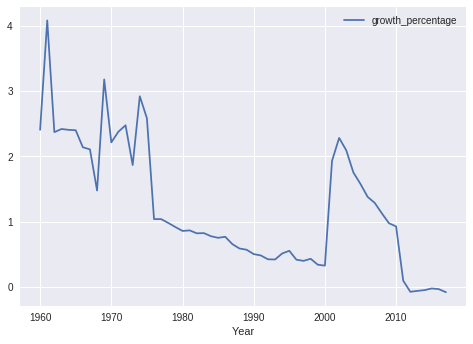

In [64]:
r3 = requests.get("https://raw.githubusercontent.com/nickwilliams2020/csvhold/master/world_urban_population_growth.csv")
raw_world_urb_pop_growth = BeautifulSoup(r3.text)

raw_world_urb_pop_growth = raw_world_urb_pop_growth.getText().split("\n")[4:]

cols = None

urb_pop_growth_obs = []

for obs in raw_world_urb_pop_growth:
  if cols is not None:
    urb_pop_growth_obs.append(obs.replace("\"", '').split(",")[:-1])
  else:
    cols = obs.replace("\"", '').split(",")    
    
df = pd.DataFrame(data=urb_pop_growth_obs, columns = cols)
df
urb_pop_growth = df[df['Country Name'] == 'Japan']
urb_pop_growth = urb_pop_growth.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code' ]).T

urb_pop_growth['Year'] = urb_pop_growth.index
urb_pop_growth.columns = ['growth_percentage', 'Year']
urb_pop_growth.index = [i for i in range(0,len(urb_pop_growth.index))]

urb_pop_growth['Year'] = pd.to_numeric(urb_pop_growth['Year'], errors='coerce')
urb_pop_growth['growth_percentage'] = pd.to_numeric(urb_pop_growth['growth_percentage'], errors='coerce')
urb_pop_growth.plot.line(x='Year', y='growth_percentage')

### Retrieve and Clean Japanese Fertility Rate (births per woman)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


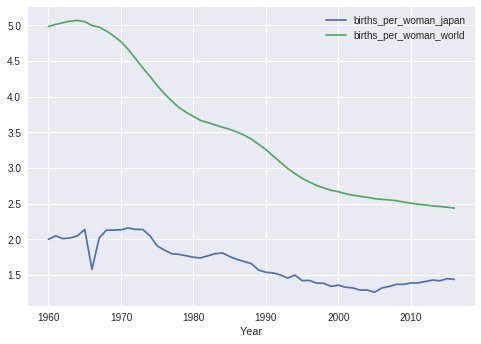

In [84]:
raw_world_fert_rates = pd.read_csv("https://raw.githubusercontent.com/nickwilliams2020/csvhold/master/world_fertility_rates.csv")
raw_world_fert_rates

japan_fert_rate = raw_world_fert_rates[raw_world_fert_rates['Country Name'].isin(['Japan', 'World'])]

japan_fert_rate = japan_fert_rate.drop(columns=['Country Name', 'Country Code', 'Indicator Code' ]).T

japan_fert_rate['Year'] = japan_fert_rate.index
japan_fert_rate.columns = ['births_per_woman_japan', 'births_per_woman_world', 'Year']
japan_fert_rate.index = [i for i in range(0,len(japan_fert_rate.index))]
japan_fert_rate
japan_fert_rate['Year'] = pd.to_numeric(japan_fert_rate['Year'], errors='coerce')
japan_fert_rate['births_per_woman_japan'] = pd.to_numeric(japan_fert_rate['births_per_woman_japan'], errors='coerce')
japan_fert_rate['births_per_woman_world'] = pd.to_numeric(japan_fert_rate['births_per_woman_world'], errors='coerce')

japan_fert_rate.plot.line(x='Year', y=['births_per_woman_japan', 'births_per_woman_world'])

From this quick 

### Retrieve and Clean Japanese Death Rate Data (Per 1,000 People)

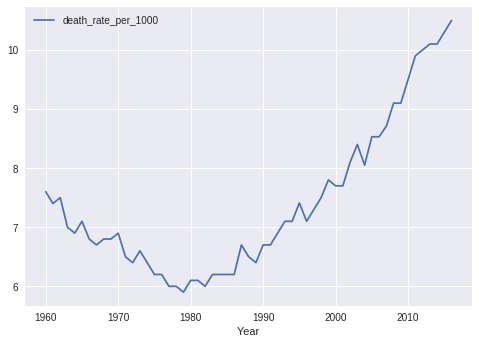

In [92]:
world_death_rates = pd.read_csv("https://raw.githubusercontent.com/nickwilliams2020/csvhold/master/world_death_rates.csv")
world_death_rates

japan_death_rate = world_death_rates[world_death_rates['Country Name'] == 'Japan']

japan_death_rate = japan_death_rate.drop(columns=['Country Name', 'Country Code', 'Indicator Code', 'Indicator Name' ]).T

japan_death_rate['Year'] = japan_death_rate.index
japan_death_rate.columns = ['death_rate_per_1000', 'Year']

japan_death_rate.index = [i for i in range(0,len(japan_death_rate.index))]
japan_death_rate
japan_death_rate['Year'] = pd.to_numeric(japan_death_rate['Year'], errors='coerce')
japan_death_rate['death_rate_per_1000'] = pd.to_numeric(japan_death_rate['death_rate_per_1000'], errors='coerce')
japan_death_rate.plot.line(x='Year', y='death_rate_per_1000')

### Retrieve and Clean Life Expectancy at Birth Data

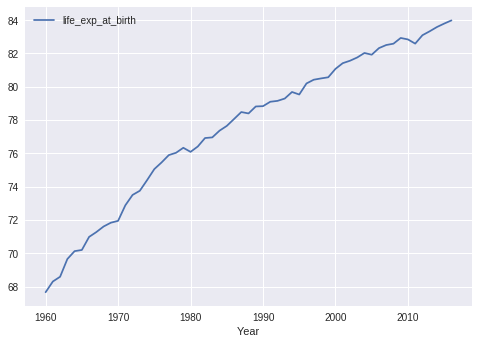

In [94]:
world_life_exp = pd.read_csv("https://raw.githubusercontent.com/nickwilliams2020/csvhold/master/world_life_expectancy.csv")
world_life_exp

japan_life_exp = world_life_exp[world_life_exp['Country Name'] == 'Japan']

japan_life_exp = japan_life_exp.drop(columns=['Country Name', 'Country Code', 'Indicator Code', 'Indicator Name' ]).T

japan_life_exp['Year'] = japan_life_exp.index
japan_life_exp.columns = ['life_exp_at_birth', 'Year']

japan_life_exp.index = [i for i in range(0,len(japan_life_exp.index))]

japan_life_exp['Year'] = pd.to_numeric(japan_life_exp['Year'], errors='coerce')
japan_life_exp['life_exp_at_birth'] = pd.to_numeric(japan_life_exp['life_exp_at_birth'], errors='coerce')
japan_life_exp.plot.line(x='Year', y='life_exp_at_birth')

### Retrieve and Clean Workforce Age Dependancy Data


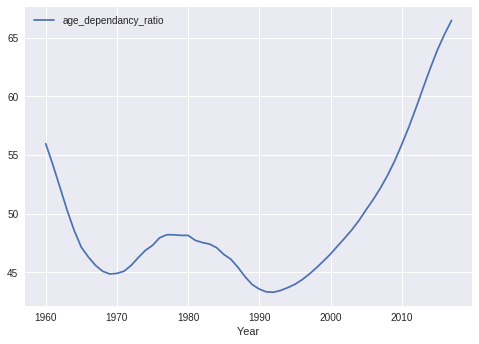

In [65]:
r3 = requests.get("https://raw.githubusercontent.com/nickwilliams2020/csvhold/master/world_age_dependancy_ratio.csv")
raw_world_age_dep = BeautifulSoup(r3.text)

raw_world_age_dep = raw_world_age_dep.getText().split("\n")[4:]

cols = None

japan_age_dep = []

for obs in raw_world_age_dep:
  if cols is not None:
    japan_age_dep.append(obs.replace("\"", '').split(",")[:-1])
  else:
    cols = obs.replace("\"", '').split(",")

df = pd.DataFrame(data=japan_age_dep, columns = cols)
japan_age_dep = df[df['Country Name'] == 'Japan']
japan_age_dep = japan_age_dep.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code' ]).T

japan_age_dep['Year'] = japan_age_dep.index
japan_age_dep.columns = ['age_dependancy_ratio', 'Year']
japan_age_dep.index = [i for i in range(0,len(japan_age_dep.index))]

japan_age_dep['Year'] = pd.to_numeric(japan_age_dep['Year'], errors='coerce')
japan_age_dep['age_dependancy_ratio'] = pd.to_numeric(japan_age_dep['age_dependancy_ratio'], errors='coerce')
japan_age_dep.plot.line(x='Year', y='age_dependancy_ratio')

### Merge All Japanese Feature Sets

In [102]:
from functools import reduce
japan_feature_sets = [total_pop, japan_life_exp, japan_age_dep, japan_death_rate, japan_fert_rate, japan_urban_pop]
df_final = reduce(lambda left, right: pd.merge(left, right, on='Year'), japan_feature_sets)
df_final

,Year,population,pop_delta,pop_delta_delta,pd_decrease,life_exp_at_birth,age_dependancy_ratio,death_rate_per_1000,births_per_woman_japan,births_per_woman_world,urban_population_count
0,1960,90095237,3787852.0,-1792606.0,0.321229,67.666098,55.969005,7.600000,2.001,4.984026,58526962.0
1,1965,94410484,4315247.0,527395.0,-0.139233,70.201951,47.129502,7.100000,2.139,5.049588,67107937.0
2,1970,99279008,4868524.0,553277.0,-0.128214,71.950244,44.904240,6.900000,2.135,4.770691,75000056.0
3,1975,106016074,6737066.0,1868542.0,-0.383801,75.057317,47.292202,6.200000,1.909,4.155118,84756490.0
4,1980,110838758,4822684.0,-1914382.0,0.284157,76.091707,48.144384,6.100000,1.750,3.722379,88958689.0
5,1985,114593751,3754993.0,-1067691.0,0.221389,77.650488,46.528320,6.200000,1.760,3.542499,92632808.0
6,1990,116920564,2326813.0,-1428180.0,0.380342,78.836829,43.561396,6.700000,1.540,3.258953,95542280.0
7,1995,118701910,1781346.0,-545467.0,0.234427,79.536341,43.974416,7.410000,1.422,2.856235,97862490.0
8,2000,119882543,1180633.0,-600713.0,0.337224,81.076098,46.558394,7.700000,1.359,2.667891,99760751.0
9,2005,120513290,630747.0,-549886.0,0.465755,81.925122,50.335955,8.530754,1.260,2.570386,109856670.0


population growth -> https://data.worldbank.org/indicator/SP.URB.GROW?locations=JP

https://data.worldbank.org/indicator/SP.POP.DPND?locations=JP

https://data.worldbank.org/indicator/SP.DYN.LE00.IN?locations=JP
